In [2]:
# packages needed
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# keras imports
from keras.applications import vgg16
from keras.layers import Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import Model
from keras import backend as K

# model selection
from sklearn.model_selection import train_test_split

# to get image names
import os, cv2, random
import ntpath

# random seed to make the kernel reproducible
random_seed = 123456789
np.random.seed(random_seed)

/home/pablo/anaconda3/envs/MLiP/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Dataset description

**************************************************************************
Content of **AVA.txt**
**************************************************************************

* **Column 1:** Index

* **Column 2:** Image ID 

* **Columns 3 - 12:** Counts of aesthetics ratings on a scale of 1-10. Column 3 has counts of ratings of 1 and column 12 has counts of ratings of 10.

* **Columns 13 - 14:** Semantic tag IDs. There are 66 IDs ranging from 1 to 66. The file tags.txt contains the textual tag corresponding to the numerical id. Each image has between 0 and 2 tags. Images with less than 2 tags have a "0" in place of the missing tag(s).

* **Column 15:** Challenge ID. The file challenges.txt contains the name of the challenge corresponding to each ID.

## Load the data

In [3]:
# directory where we are going to work on
workdir = '/media/pablo/Pablo/2018/Universidad 2017-18/TFG/Dataset/AVA_dataset/'

In [4]:
# set the correct directory
ava_dir = os.path.join(workdir, 'AVA.txt')
ava_data_pd = pd.read_csv(ava_dir, sep = ' ', header = None, names = ['Index', 'Image ID', 'Rate 1', 'Rate 2',
                                                                      'Rate 3', 'Rate 4', 'Rate 5', 'Rate 6', 
                                                                      'Rate 7', 'Rate 8', 'Rate 9','Rate 10', 
                                                                      'Sem 1', 'Sem 2', 'Challenge ID'])

# separate the labels of the image IDs
x_train = ava_data_pd.values[:,1]
y_train = ava_data_pd.values[:,2:12]

In [5]:
# sample to see if everything has been loaded correctly
ava_data_pd.sample(5)

,Index,Image ID,Rate 1,Rate 2,Rate 3,Rate 4,Rate 5,Rate 6,Rate 7,Rate 8,Rate 9,Rate 10,Sem 1,Sem 2,Challenge ID
249974,249975,325013,1,2,11,33,99,58,22,10,3,0,10,20,483
66880,66881,941801,1,1,4,20,58,57,22,4,2,2,19,0,1363
178948,178949,630511,0,2,9,14,35,63,70,50,18,9,0,0,799
93223,93224,830205,1,2,5,23,71,39,15,4,1,1,14,15,1104
99395,99396,954817,4,4,14,18,33,38,16,7,2,2,0,0,1387


In [6]:
# metrics regarding score distribution
mean_scores = np.sum(y_train * np.arange(1, 11), axis = 1) / (np.sum(y_train, axis = 1) + 1)
mean_scores_rep = np.repeat(mean_scores, 10, axis = 0).reshape(255530, 10)
stds_scores = np.sqrt((np.sum(np.abs(np.arange(1, 11) - mean_scores_rep) ** 2 * y_train, axis = 1)) / (np.sum(y_train, axis = 1)))

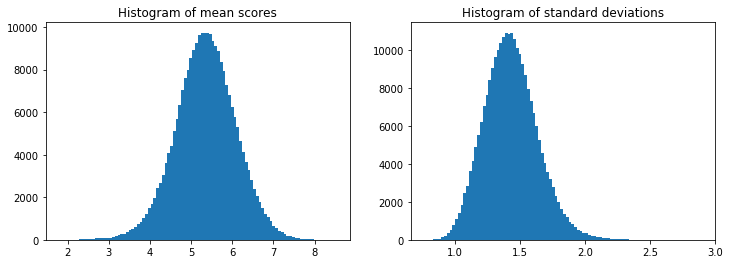

In [7]:
# rating distribution mean over all the dataset
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Histogram of mean scores')
plt.hist(mean_scores, bins = 100)
plt.subplot(1, 2, 2)
plt.title('Histogram of standard deviations')
plt.hist(stds_scores, bins = 100)
plt.show()

Filename:  303255.jpg


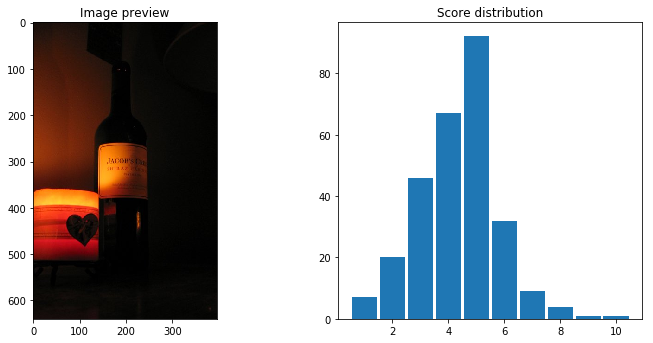

Filename:  13458.jpg


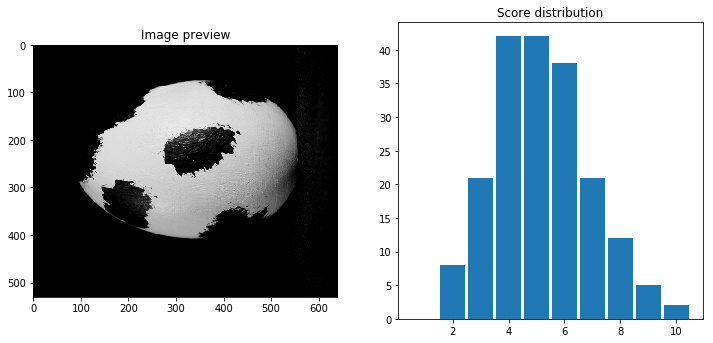

Filename:  543708.jpg


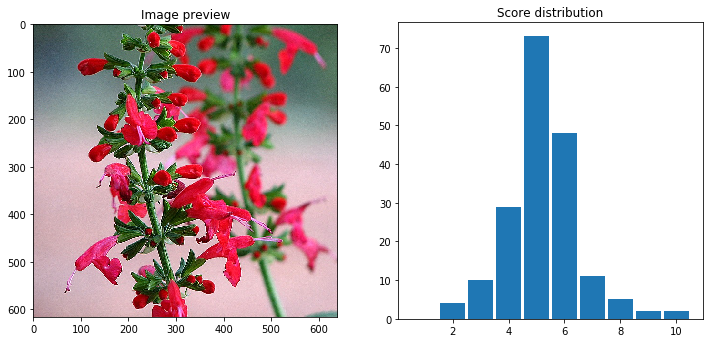

In [8]:
# number of random samples to be plotted
n_rand_samples = 3

# define directory of training images
train_dir_images = os.path.join(workdir, 'images_extracted', 'images')

# plot n_rand_samples
for i in range(n_rand_samples):

    # pick random training image
    case = os.path.join(train_dir_images, random.choice(os.listdir(train_dir_images)))
    case_filename = os.path.splitext(ntpath.basename(case))[0] + '.jpg'
    print("Filename: ", case_filename)
    
    # plot the score distribution of the image
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 2)

    punt = y_train[x_train == int(os.path.splitext(ntpath.basename(case))[0])][0]
    plt.title('Score distribution')
    plt.bar(np.arange(1,11), height = punt, width = 0.9)

    # open image with opencv and visualize it
    plt.subplot(2, 2, 1)

    image = cv2.cvtColor(cv2.imread(case, 1), cv2.COLOR_BGR2RGB) # cv2 loads an image BGR rather than RGB
    plt.title('Image preview')
    plt.imshow(image)
    plt.show()

**********************

Since the **255530** images are impossible to be loaded in memory, we will use a technique that will let us load images during the training process. Using this technique, we won't need to create a dataset beforehand and then use it to train you network, but we will just have a list of training images available, and images will be extracted **on-the-fly** during training. This strategy allows to save time in the preparation the static dataset as well as memmory, and allows the use of a dynamic generation of batches, where data augmentation can also be applied on-the-fly.

In [9]:
class BatchCreator:
    
    def __init__(self, x, y):
        '''
        dataset: numpy array containing the Image IDs and the Rating distribution
        '''
        self.imgs_ids = x       # store the Image IDs
        self.imgs_rates = y  # store the Image rate distribution

    def create_batch(self, batch_size):
        '''
        Returns an array of data (x) with corresponding labels (y) in one-hot structure
        '''
        
        x_data = np.zeros((batch_size, 224, 224, 3), dtype = 'uint8')
        y_data = np.zeros((batch_size, 10)) # one-hot encoding
        
        # load and return "batch_size" images
        for i in range(batch_size):
            
            # select case (generate random index)
            img_index = np.random.choice(len(self.imgs_ids))
            
            # obtain the path
            case = os.path.join(train_dir_images, str(self.imgs_ids[img_index]) + '.jpg')
            
            # load image, change color structure, resize it and store it
            x_data[i] = cv2.resize(cv2.cvtColor(cv2.imread(case, 1), cv2.COLOR_BGR2RGB), (224, 224))
            
            # store score distribution
            y_data[i] = self.imgs_rates[img_index]
        
        return x_data, y_data
        
    def get_generator(self, batch_size):
        '''
        returns a generator that will yield batches infinitely
        '''
        while True:
            yield self.create_batch(batch_size)

Once the BatchCreator is defined, it will be tested

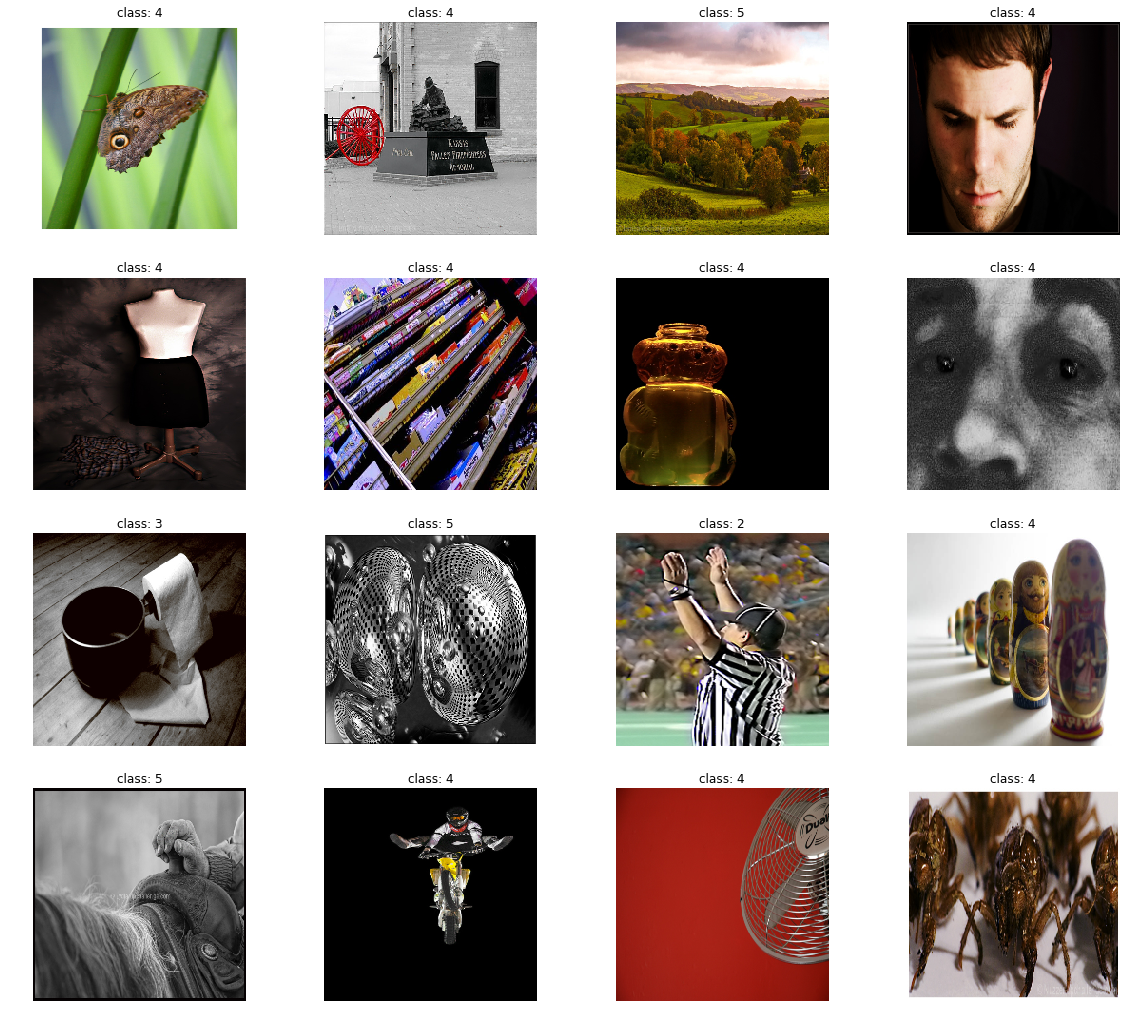

In [10]:
batch_creator = BatchCreator(x_train, y_train)

# create a batch
x, y = batch_creator.create_batch(16)

# visualize it
matplotlib.rcParams['figure.figsize'] = (20, 18)
f, axes = plt.subplots(4, 4)
i = 0;
for ax_row in axes:
    for ax in ax_row:
        ax.imshow(x[i])
        ax.axis('off')
        ax.set_title('class: {}'.format(np.argmax(y[i])))
        i += 1
plt.show()

Once we have created the BatchCreater, we will split our dataset in trainig and validation.

In [11]:
# split train and validationy_train
x_train, x_validation, y_train, y_validation = train_test_split(x_train, 
                                                                y_train, 
                                                                test_size = 0.1,
                                                                random_state = random_seed)

After splitting the dataset, we will define the loss function `EMD` (Earth Mover’s Distance). Whose equation is the following one:

$$ EMD(p, \widehat{p}) = \left ( \frac{1}{N} \sum_{k=1}^{N} \left | CDF_{p} \left ( k \right ) - CDF_{\widehat{p}}\left ( k \right ) \right |^{r} \right )^{1/r} $$

Where `CDF` is the cummulative distribution, and `r` is fixed to 2 to penalize the Euclidean distance between the
CDFs and allows easier optimization when working with gradient descent.

In [12]:
def emd_loss(y_true, y_pred):
    '''
    Earth Mover's Distance loss
    '''
    cdf_p    = K.cumsum(y_true, axis = -1)
    cdf_phat = K.cumsum(y_pred, axis = -1)
    loss     = K.mean(K.sqrt(K.mean(K.square(K.abs(cdf_p - cdf_phat)), axis = -1)))
    
    return loss


In [13]:
# load the pre-trained model
vgg_16 = vgg16.VGG16()

# remove last layer
vgg_16.layers.pop()

# freeze all the layers
for layer in vgg_16.layers:
    layer.trainable = False

# add last FC layer
x = Dropout(0.5)(vgg_16.output)
x = Dense(10, activation = 'softmax')(x)

# create the new model
vgg_16 = Model(vgg_16.input, x)

# show summary
vgg_16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
# learning rat
learning_rate = 1e-3

# optimizer and model compile
optimizer = Adam(lr = learning_rate)
vgg_16.compile(optimizer, loss = emd_loss)

In [ ]:
# training
checkpoint = ModelCheckpoint('weights/best_model.h5', 
                             monitor = 'val_loss',
                             verbose = 1,
                             save_weights_only = True,
                             save_best_only = True,
                             mode = 'min')

# batch size and number of epochs
batch_size = 100
epochs = 2

# create the Batches and obtain the generatoros
batch_creator_train = BatchCreator(x_train, y_train)
betch_creator_val   = BatchCreator(x_validation, y_validation)

train_generator = batch_creator_train.get_generator(batch_size)
val_generator   = betch_creator_val.get_generator(batch_size)

# fit the model
vgg_16.fit_generator(train_generator,
                     steps_per_epoch = 20,
                     epochs = epochs,
                     verbose = 1, 
                     callbacks = [checkpoint],
                     validation_data = val_generator,
                     validation_steps = 20)

Epoch 1/2
